In [8]:
# Data Manipulation and Numerics
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Machine Learning - Feature Selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Machine Learning - Modeling
from sklearn.linear_model import LinearRegression

# Machine Learning - Evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error

# Display settings
pd.set_option('display.max_columns', None) # Show all columns
sns.set_style('whitegrid') # Set seaborn style
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size

## 1. Data Loading and Initial Inspection


In [22]:
# Load the data from the CSV file
df_raw = pd.read_csv("cumulative.csv")
print("Dataset loaded successfully.")
print(f"Initial dataset shape: {df_raw.shape}")


# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df_raw.head())

# Display basic information (data types, non-null counts)
print("\nDataset Information:")
df_raw.info()

# Display descriptive statistics for numerical columns
print("\nDescriptive Statistics (Numerical Columns):")
print(df_raw.describe())

# Display descriptive statistics for categorical columns
print("\nDescriptive Statistics (Categorical/Object Columns):")
print(df_raw.describe(include='object'))


# Check for initial missing values summary
print("\nInitial Missing Values Summary (Top 10):")
missing_counts = df_raw.isnull().sum()
print(missing_counts[missing_counts > 0].sort_values(ascending=False).head(10))

Dataset loaded successfully.
Initial dataset shape: (9564, 50)

First 5 rows of the dataset:
   rowid     kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0      1  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1      2  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2      3  10811496  K00753.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
3      4  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4      5  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  \
0      1.000              0              0              0              0   
1      0.969              0              0              0              0   
2      0.000              0              1              0              0   
3      0.000              0              1              0              0   
4      1.000              0              0    

### 1.1 Visualize Initial Missing Data



C:\Users\naray\AppData\Local\Temp\ipykernel_8540\1242609828.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_info.index, y=missing_info['Percentage'], palette='viridis')


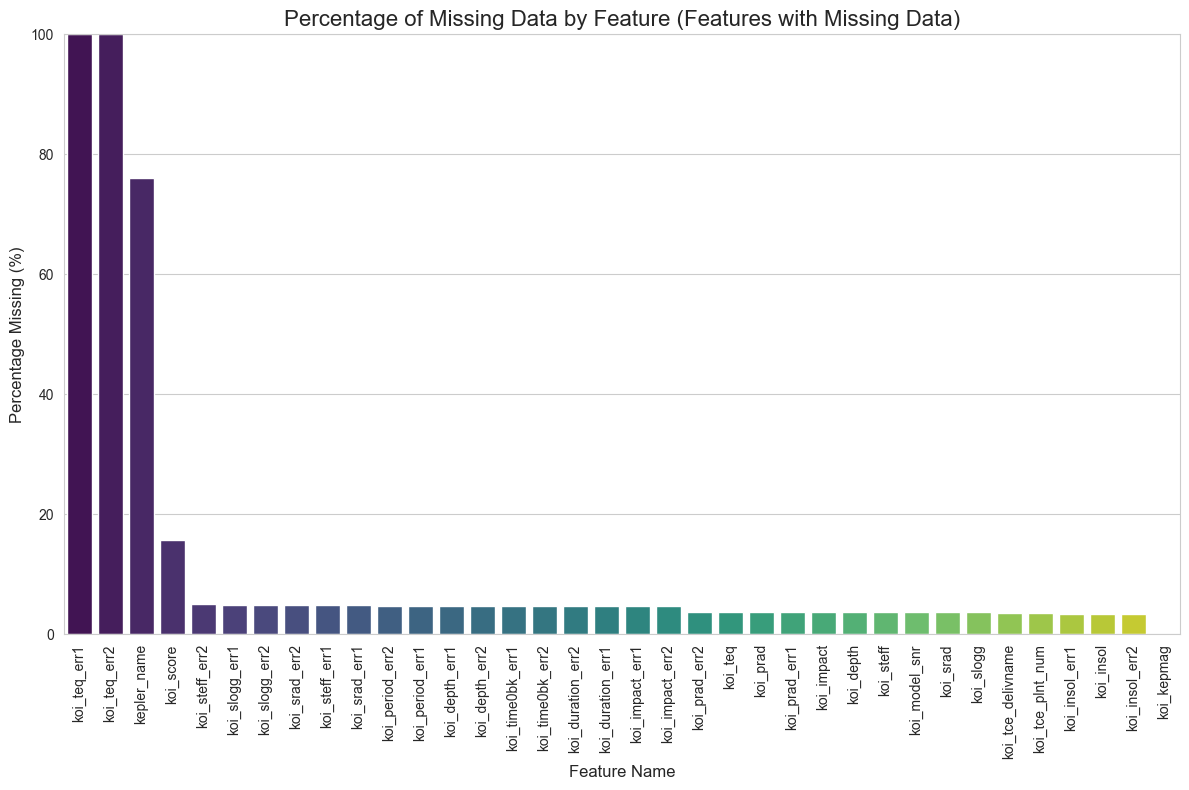

In [23]:

# Calculate missing values percentage
missing_percentage = (df_raw.isnull().sum() / len(df_raw)) * 100
missing_info = pd.DataFrame({'Count': missing_counts[missing_counts > 0],
                             'Percentage': missing_percentage[missing_percentage > 0]})
missing_info = missing_info.sort_values(by='Percentage', ascending=False)

# Plot missing values percentage for columns with missing data
if not missing_info.empty:
    plt.figure(figsize=(12, 8))
    sns.barplot(x=missing_info.index, y=missing_info['Percentage'], palette='viridis')
    plt.title('Percentage of Missing Data by Feature (Features with Missing Data)', fontsize=16)
    plt.xlabel('Feature Name', fontsize=12)
    plt.ylabel('Percentage Missing (%)', fontsize=12)
    plt.xticks(rotation=90)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

else:
    print("\nNo missing data found in the initial dataset.")

## 2. Data Cleaning and Manipulation




No unnamed columns found.

Analyzing target variable 'koi_score' before cleaning:
count    8054.000000
mean        0.480829
std         0.476928
min         0.000000
25%         0.000000
50%         0.334000
75%         0.998000
max         1.000000
Name: koi_score, dtype: float64

Dropped 1510 rows where 'koi_score' was missing.
Shape after dropping missing target rows: (8054, 50)

Dropped 3482 rows where 'koi_score' <= 1e-05.
Shape after removing near-zero target values: (4572, 50)

Analyzing target variable 'koi_score' after cleaning:
count    4572.000000
mean        0.847025
std         0.300809
min         0.001000
25%         0.908750
50%         0.996000
75%         1.000000
max         1.000000
Name: koi_score, dtype: float64


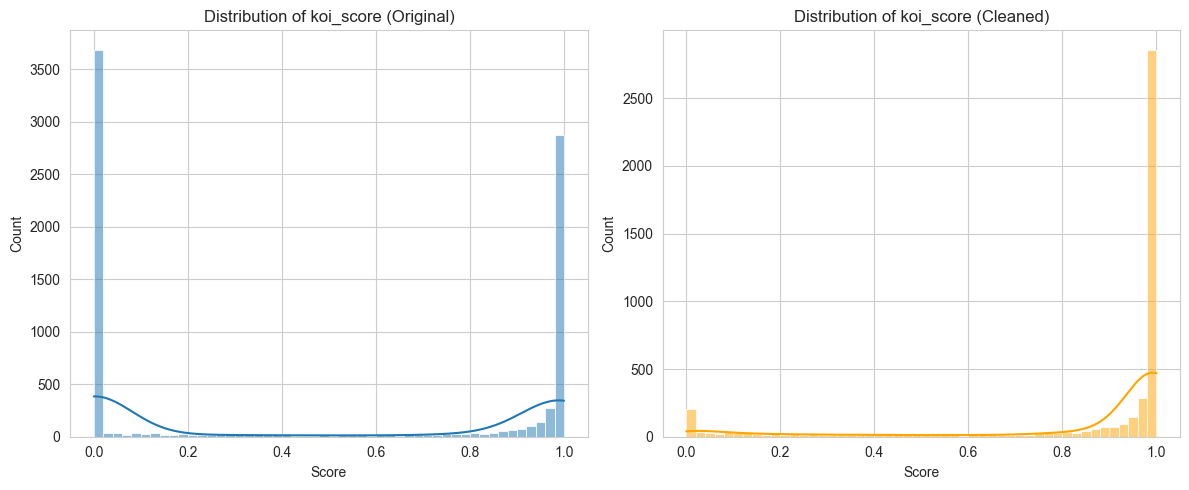


Separating features (X) and target (y = koi_score)...
Shape of features (X): (4572, 49)
Shape of target (y): (4572,)

Checking for columns with all missing values in features...
Dropped 2 columns from X where all values were missing.
Shape of features (X) after dropping all-NaN columns: (4572, 47)


In [24]:

df = df_raw.copy()

# Drop unnamed index columns 
unnamed_cols = df.columns[df.columns.str.contains("^Unnamed")]
if not unnamed_cols.empty:
    print(f"\nDropping unnamed columns: {list(unnamed_cols)}")
    df = df.drop(columns=unnamed_cols)
    print(f"Shape after dropping unnamed columns: {df.shape}")
else:
    print("\nNo unnamed columns found.")


# --- Target Variable Handling ---
target_col = "koi_score"

# Check if target column exists
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in the dataset.")

# Analyze the target variable before cleaning
print(f"\nAnalyzing target variable '{target_col}' before cleaning:")
print(df[target_col].describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df[target_col], kde=True, bins=50)
plt.title(f"Distribution of {target_col} (Original)")
plt.xlabel("Score")

# Drop rows where the target variable 'koi_score' is missing
initial_rows = df.shape[0]
df = df.dropna(subset=[target_col])
rows_dropped = initial_rows - df.shape[0]
print(f"\nDropped {rows_dropped} rows where '{target_col}' was missing.")
print(f"Shape after dropping missing target rows: {df.shape}")

# Remove rows where koi_score is zero or very small (potential outliers or non-detections)
# Using a small epsilon to avoid issues with floating point precision
epsilon = 1e-5
initial_rows = df.shape[0]
df = df[df[target_col] > epsilon]
rows_dropped = initial_rows - df.shape[0]
print(f"\nDropped {rows_dropped} rows where '{target_col}' <= {epsilon}.")
print(f"Shape after removing near-zero target values: {df.shape}")

# Re-analyze the target variable after cleaning
print(f"\nAnalyzing target variable '{target_col}' after cleaning:")
print(df[target_col].describe())

plt.subplot(1, 2, 2)
sns.histplot(df[target_col], kde=True, bins=50, color='orange')
plt.title(f"Distribution of {target_col} (Cleaned)")
plt.xlabel("Score")
plt.tight_layout()
plt.show()


# --- Feature and Target Separation ---
print(f"\nSeparating features (X) and target (y = {target_col})...")
y = df[target_col]
X = df.drop(columns=[target_col])
print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")

# Drop columns where *all* values are missing in the feature set
print("\nChecking for columns with all missing values in features...")
initial_cols = X.shape[1]
X = X.dropna(axis=1, how='all')
cols_dropped = initial_cols - X.shape[1]
if cols_dropped > 0:
    print(f"Dropped {cols_dropped} columns from X where all values were missing.")
    print(f"Shape of features (X) after dropping all-NaN columns: {X.shape}")
else:
    print("No columns with all missing values found in X.")

## 3. Data Preprocessing




Identifying categorical features for one-hot encoding...
Found 5 categorical columns: ['kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_tce_delivname']
Found 42 numerical columns.
Applying one-hot encoding...
Shape of features after one-hot encoding: (4572, 6874)

Data types after encoding:
bool       6832
float64      36
int64         6
Name: count, dtype: int64

Checking for remaining missing values in features before imputation:
koi_period_err1      37
koi_period_err2      37
koi_time0bk_err1     37
koi_time0bk_err2     37
koi_impact           10
koi_impact_err1      37
koi_impact_err2      37
koi_duration_err1    37
koi_duration_err2    37
koi_depth            10
koi_depth_err1       37
koi_depth_err2       37
koi_prad             10
koi_prad_err1        10
koi_prad_err2        10
koi_teq              10
koi_insol             7
koi_insol_err1        7
koi_insol_err2        7
koi_model_snr        10
koi_steff            10
koi_steff_err1       24
koi_steff_e

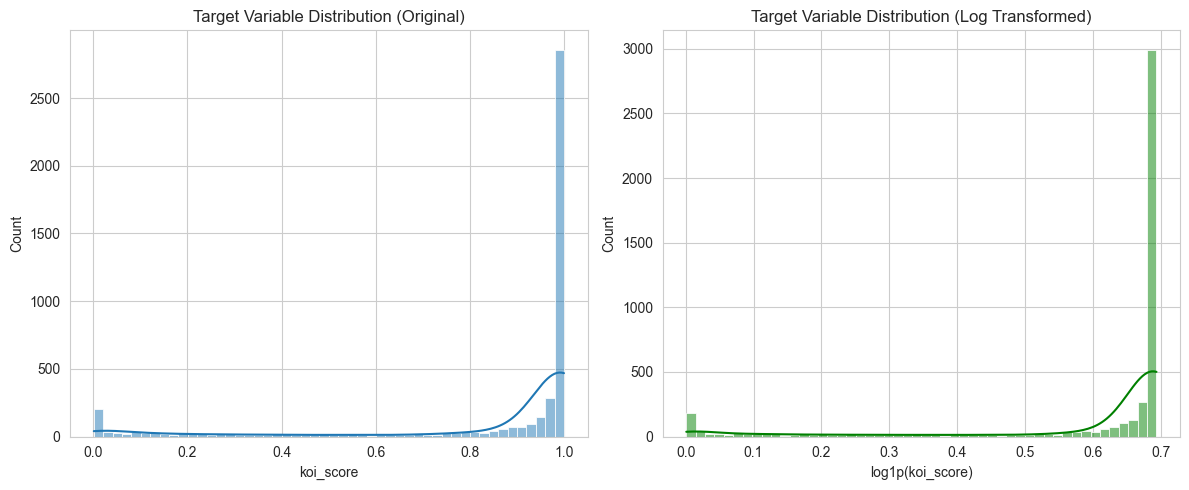

Log transformation applied.

Target Variable Statistics (Log Transformed):
count    4572.000000
mean        0.596102
std         0.200395
min         0.001000
25%         0.646449
50%         0.691145
75%         0.693147
max         0.693147
Name: koi_score, dtype: float64


In [12]:
# --- 3.1 One-Hot Encode Categorical Features ---
print("\nIdentifying categorical features for one-hot encoding...")
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=np.number).columns

print(f"Found {len(categorical_cols)} categorical columns: {list(categorical_cols)}")
print(f"Found {len(numerical_cols)} numerical columns.")

# Apply one-hot encoding
if not categorical_cols.empty:
    print("Applying one-hot encoding...")
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dummy_na=False) # Keep NaN handling for imputer
    print(f"Shape of features after one-hot encoding: {X_encoded.shape}")
    # Store encoded column names for later use (e.g., feature importance)
    encoded_feature_names = X_encoded.columns.tolist()
else:
    print("No categorical columns to encode.")
    X_encoded = X.copy() # Keep as is if no categorical columns
    encoded_feature_names = X_encoded.columns.tolist()

# Display data types after encoding
print("\nData types after encoding:")
print(X_encoded.dtypes.value_counts())


# --- 3.2 Impute Missing Values (Features) ---
print("\nChecking for remaining missing values in features before imputation:")
missing_values = X_encoded.isnull().sum()
print(missing_values[missing_values > 0])

# Impute missing values using the mean strategy
imputer = SimpleImputer(strategy='mean')

X_imputed_array = imputer.fit_transform(X_encoded)
X_imputed = pd.DataFrame(X_imputed_array, columns=encoded_feature_names, index=X_encoded.index)

print("Imputation complete.")
print(f"Missing values in features after imputation: {X_imputed.isnull().sum().sum()}")


# --- 3.3 Scale Numerical Features ---
print("\nScaling features using StandardScaler...")

# Display statistics before scaling
print("Descriptive Statistics (Features) BEFORE Scaling:")
print(X_imputed.describe())

scaler = StandardScaler()

X_scaled_array = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled_array, columns=encoded_feature_names, index=X_imputed.index)

print("Scaling complete.")

# Display statistics after scaling
print("\nDescriptive Statistics (Features) AFTER Scaling:")
print(X_scaled.describe())


# --- 3.4 Transform Target Variable ---
print("\nApplying log transformation (log1p) to the target variable 'y'...")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins=50)
plt.title("Target Variable Distribution (Original)")
plt.xlabel(target_col)

# Apply log(1 + x) transformation
y_log = np.log1p(y)

plt.subplot(1, 2, 2)
sns.histplot(y_log, kde=True, bins=50, color='green')
plt.title("Target Variable Distribution (Log Transformed)")
plt.xlabel(f"log1p({target_col})")
plt.tight_layout()
plt.show()

print("Log transformation applied.")
print("\nTarget Variable Statistics (Log Transformed):")
print(y_log.describe())

## 4. Train/Test Split


In [27]:
# Split the data into training and testing sets (80% train, 20% test)
test_size = 0.2
random_state = 42

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, y_log,
    test_size=test_size,
    random_state=random_state
)

print("\nData split into training and testing sets.")
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train_log.shape}")
print(f"Testing target shape: {y_test_log.shape}")

print("\nRefitting Imputer on training data...")
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=encoded_feature_names, index=X_train.index)
X_test = pd.DataFrame(imputer.transform(X_test), columns=encoded_feature_names, index=X_test.index)
print("Imputer refitted and applied.")

print("\nRefitting Scaler on training data...")
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=encoded_feature_names, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=encoded_feature_names, index=X_test.index)
print("Scaler refitted and applied.")


Data split into training and testing sets.
Training features shape: (3657, 6874)
Testing features shape: (915, 6874)
Training target shape: (3657,)
Testing target shape: (915,)

Refitting Imputer on training data...
Imputer refitted and applied.

Refitting Scaler on training data...
Scaler refitted and applied.


## 5. Model Training: Linear Regression



In [18]:

print("\nTraining Linear Regression model on ALL preprocessed features...")

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the full training set (X_train)

model.fit(X_train, y_train_log)

print("Linear Regression model trained successfully.")

# Display model coefficients (optional)

all_feature_names = encoded_feature_names 
print(f"\nModel Coefficients ({len(all_feature_names)} Features):")
coefficients = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': model.coef_})
print(coefficients.sort_values(by='Coefficient', key=abs, ascending=False).head(10)) # Show top 10 by absolute value
print("\nModel Intercept:")
print(model.intercept_)


Training Linear Regression model on ALL preprocessed features...
Linear Regression model trained successfully.

Model Coefficients (6874 Features):
                              Feature  Coefficient
6873  koi_pdisposition_FALSE POSITIVE    -0.041315
6872   koi_disposition_FALSE POSITIVE    -0.039851
4                       koi_fpflag_co    -0.028773
2                       koi_fpflag_nt    -0.018690
3                       koi_fpflag_ss    -0.015899
0                               rowid    -0.013227
3012             kepoi_name_K03119.01    -0.010565
6                          koi_period    -0.010349
362              kepoi_name_K00326.01    -0.010187
6871        koi_disposition_CONFIRMED     0.008664

Model Intercept:
0.5955317675328426


## 6. Prediction and Evaluation



In [19]:

print("\nMaking predictions on the test set...")
y_pred_log = model.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

# Ensure predictions are non-negative
y_pred = np.maximum(0, y_pred)

print("Predictions generated and inverse transformed.")

# --- Calculate Evaluation Metrics ---
print("\nEvaluating model performance:")
# (Metric calculations remain the same)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
medae = median_absolute_error(y_true, y_pred)
epsilon = 1e-6
mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Print metrics
print(f"Mean Squared Error (MSE):           {mse:.4f}")
print(f"Root Mean Squared Error (RMSE):     {rmse:.4f}")
print(f"Mean Absolute Error (MAE):          {mae:.4f}")
print(f"Median Absolute Error (MedAE):      {medae:.4f}")
print(f"R^2 Score (Coefficient of Det.):    {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

metrics = {
    'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MedAE': medae, 'R2': r2, 'MAPE': mape
}


Making predictions on the test set...
Predictions generated and inverse transformed.

Evaluating model performance:
Mean Squared Error (MSE):           0.0181
Root Mean Squared Error (RMSE):     0.1344
Mean Absolute Error (MAE):          0.0999
Median Absolute Error (MedAE):      0.0750
R^2 Score (Coefficient of Det.):    0.7914
Mean Absolute Percentage Error (MAPE): 456.22%


## 7. Data Visualization 



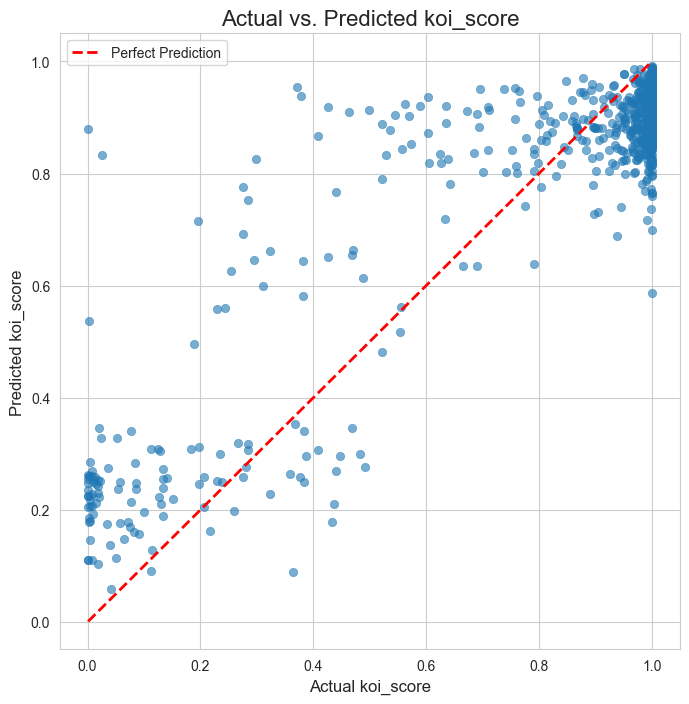

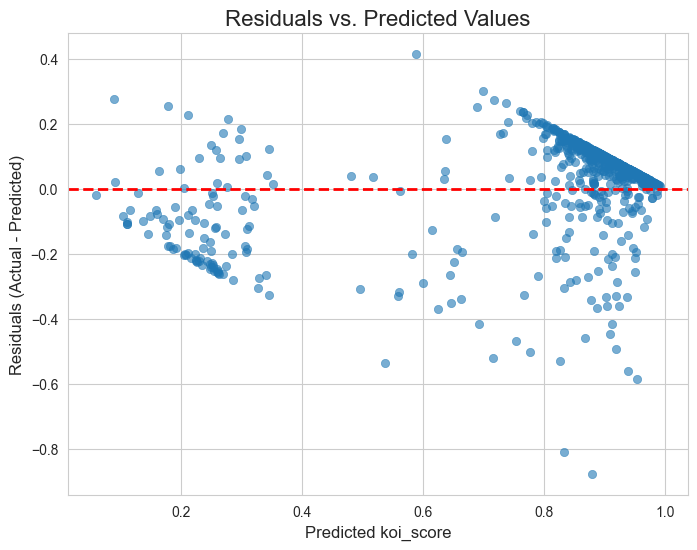

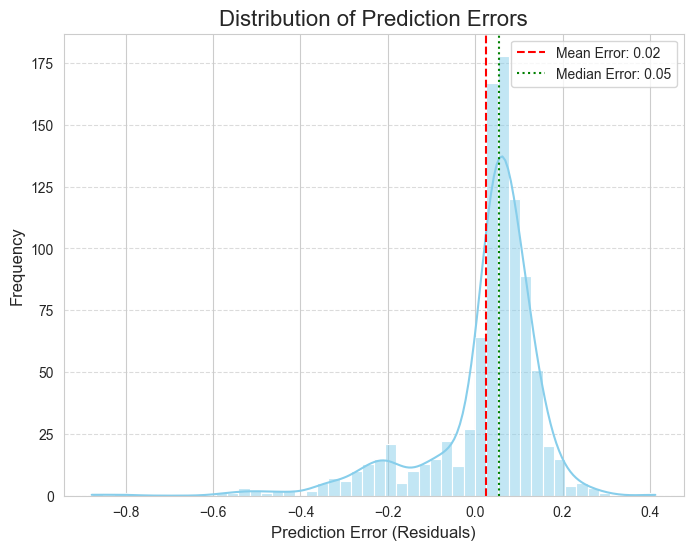

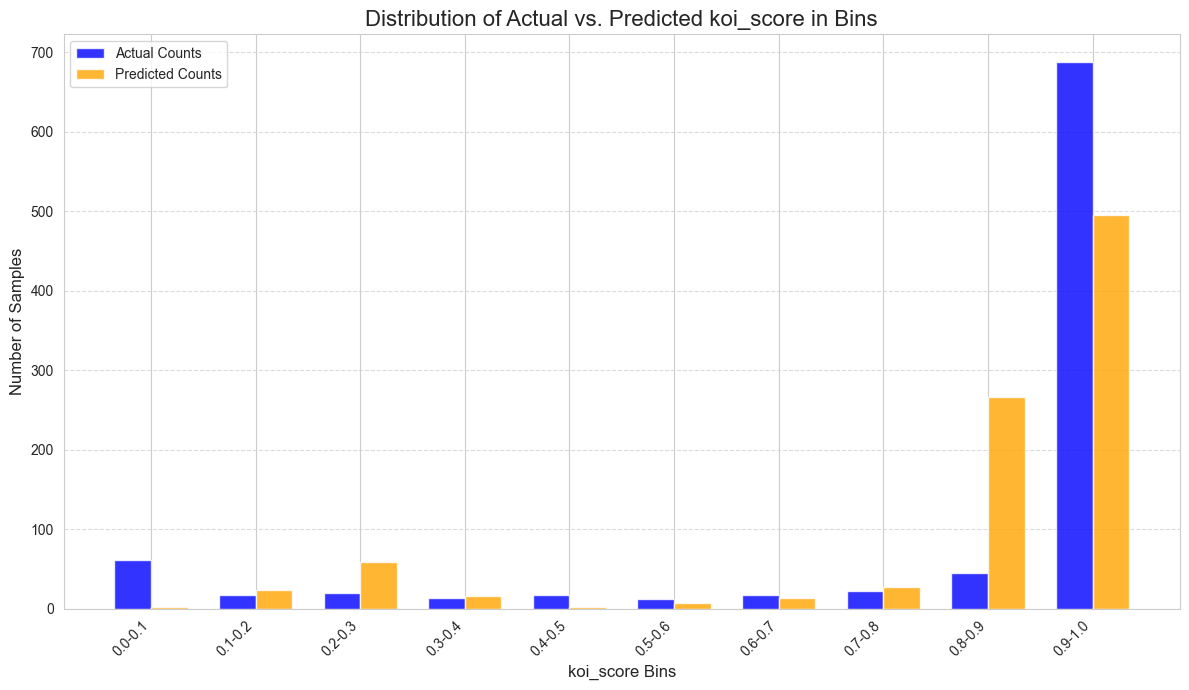


Analysis and Visualization Complete.


In [26]:
#  Actual vs. Predicted Plot ---
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, edgecolor=None)
# Add a line for perfect predictions (y=x)
max_val = max(y_true.max(), y_pred.max())
min_val = min(y_true.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual koi_score", fontsize=12)
plt.ylabel("Predicted koi_score", fontsize=12)
plt.title("Actual vs. Predicted koi_score", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# --- Residuals vs. Predicted Plot ---
# Residuals = Actual - Predicted
residuals = y_true - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor=None)
plt.axhline(0, color='red', linestyle='--', lw=2) # Line at zero error
plt.xlabel("Predicted koi_score", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.title("Residuals vs. Predicted Values", fontsize=16)
plt.grid(True)
plt.show()
# Look for patterns: Ideally, residuals should be randomly scattered around zero.
# Patterns (like a curve or funnel shape) might indicate non-linearity or heteroscedasticity.

# ---  Error Distribution Plot ---
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color='skyblue')
plt.axvline(residuals.mean(), color='red', linestyle='--', lw=1.5, label=f'Mean Error: {residuals.mean():.2f}')
plt.axvline(residuals.median(), color='green', linestyle=':', lw=1.5, label=f'Median Error: {residuals.median():.2f}')
plt.xlabel("Prediction Error (Residuals)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Prediction Errors", fontsize=16)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# Look for: Normality (bell shape), centered around zero.


# ---  Binned Barplot of Actual vs Predicted Counts ---

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
num_bins = 10
bins = np.linspace(min_val, max_val, num_bins + 1)
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(num_bins)]

# Cut data into bins
actual_binned = pd.cut(y_true, bins=bins, labels=labels, include_lowest=True, right=True)
pred_binned = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True, right=True)

# Get value counts for each bin
actual_counts = actual_binned.value_counts().sort_index()
pred_counts = pred_binned.value_counts().sort_index()

# Create the plot
plt.figure(figsize=(12, 7))
bar_width = 0.35
index = np.arange(len(labels))

plt.bar(index - bar_width/2, actual_counts.reindex(labels, fill_value=0), bar_width, label='Actual Counts', alpha=0.8, color='blue')
plt.bar(index + bar_width/2, pred_counts.reindex(labels, fill_value=0), bar_width, label='Predicted Counts', alpha=0.8, color='orange')

plt.xlabel("koi_score Bins", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Distribution of Actual vs. Predicted koi_score in Bins", fontsize=16)
plt.xticks(index, labels, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


print("\nAnalysis and Visualization Complete.")